In [1]:
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm

import config
import utility.df
import utility.iolib
import utility.plotlib
import model.performance

from utility.feature import Feature
from utility.feature import FeatureCM
from model.dataEngine import DataEngine

#env = sys.argv[1] if len(sys.argv) > 2 else "dev"

## Configuration and Data Loading

In [2]:
# Setup configuration
cfg = config.ResearchConfig
time_format = cfg.CSV_TIME_FORMAT
date_format = cfg.CSV_DATE_FORMAT
cutoff_date = pd.to_datetime(cfg.CUTOFF_DATE, format=cfg.CSV_DATE_FORMAT)

# Retrieve data
df_subspt, df_lesson, df_incomp, df_crclum, df_pupils = utility.iolib.retrieve_data(cfg)
print("Complete loading data for subscription and lesson history!")

# Filter data
cutoff_date = pd.to_datetime(cfg.CUTOFF_DATE, format=cfg.CSV_DATE_FORMAT)
first_date_impFromData = df_subspt.subscription_start_date.min()

pupils_toBeRemoved = utility.df.filter_subspt_data(
    df_subspt, first_date_impFromData, cutoff_date, remove_annual_subspt=cfg.MONTHLY_ONLY)
df_lesson1 = df_lesson[~df_lesson['pupilId'].isin(pupils_toBeRemoved)]
df_incomp1 = df_incomp[~df_incomp['pupilId'].isin(pupils_toBeRemoved)]
df_subspt1 = df_subspt[~df_subspt['pupilId'].isin(pupils_toBeRemoved)]

df_subspt1 = utility.df.compute_customer_month(df_subspt1, cfg)

# Construct dates frame
df_datesFrame = utility.df.construct_dates_frame(df_subspt1, df_lesson1, df_incomp1, cfg)
df_datesFrame.fillna(0, inplace=True)

Complete loading data for subscription and lesson history!
By the cutoff date 2018-04-20, there are 1234 active subscriptions.
These subscribers shall be removed from the analysis because we have no evidence to know the lifetime of their subscriptions. 

In the first month of dataset starting from 2014-01-01, there are 154 renewal or new subscriptions.
These subscribers shall be removed from the analysis because we have no evidence to show if they renewed or newly joined. 

We also choose to remove 2525 annual subscribers. 

In summary, there are 3013/5685 subscribers being removed from the dataset in the analysis. 

Calculate customer month in the subscription table.


100%|██████████| 2672/2672 [00:02<00:00, 927.69it/s] 


Construct data-driven dates frame.
The dates frame has already been assigned customer month and saved in a file. The file has been loaded!


## Features Preparation

In [3]:
data_engine = DataEngine(df_subspt1, df_datesFrame, df_lesson1, df_incomp1, df_pupils, cfg)
data_engine.aggregate_features()

ftr_list = ['usage', 'usage_complete', 'usage_incomplete', 'rate_incomplete_usage',
            'last_access', 
            'age', 'math_age',
            'rate_assess', 'sum_help', 
            'progress', 'progress_delta',
            'num_attempt',  'num_complete', 'num_incomplete', 'rate_incomplete_num', 
            'num_pass', 'num_replay', 'num_fail',
            'holiday',
            'age_diff'
           ]
ftr_list = ['usage_complete', 'usage_incomplete', 'usage',
            'last_access', 
            'math_age', 'age',
            'rate_assess', 'sum_help', 
            'progress', 'progress_delta',
            'num_complete',  'num_incomplete', 'num_attempt', 
            'num_pass', 'num_replay', 'num_fail',
            'age_diff'
           ]

data_engine.select_features(ftr_list)
data_engine.transform_boxCox()

X = data_engine.data_
Xt = data_engine.data_bc_
y = data_engine.target_

df_whizz1 = data_engine.df_whizz_

Construct feature object.
+ Add feature: usage time.
+ Add feature: progressions.
+ Add feature: pupils' age.
+ Add feature: math age.
+ Add feature: outcome.
+ Add feature: score.
+ Add feature: hardship.
Aggregate data over customer months.


100%|██████████| 49/49 [00:11<00:00,  4.27it/s]


## Feature Distribution (Raw)

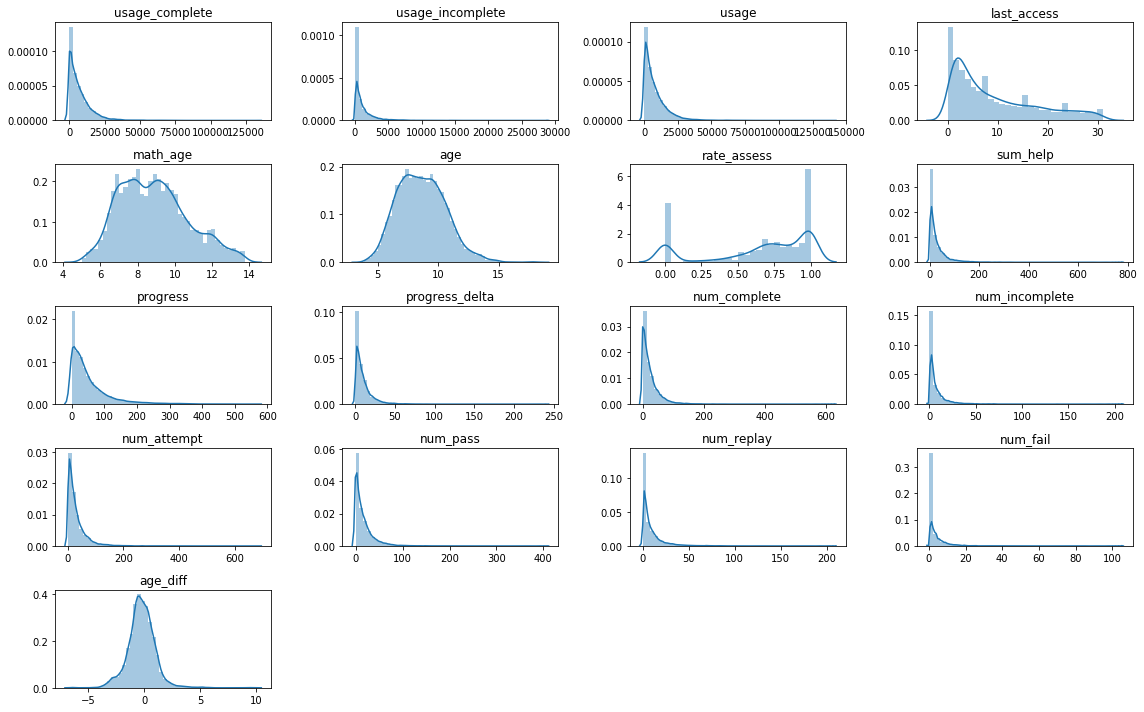

In [4]:
ftr_list_nontransform = []
utility.plotlib.feature_distribution(
    df_whizz1, ftr_list, 4, cfg, 
    transform=False, ftr_list_nontransform=ftr_list_nontransform)

## Feature Distribution (Transformed and Scaled)

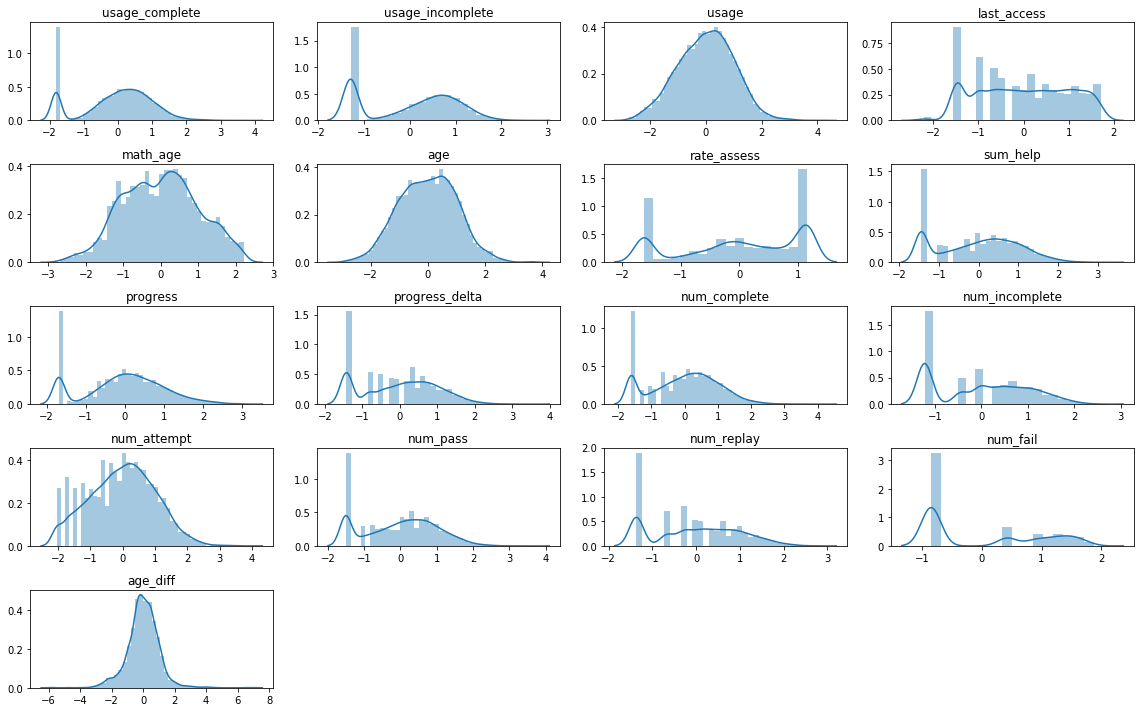

In [21]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(Xt)
Xt_scaled = scaler.transform(Xt)

scaler.fit(X)
X_scaled = scaler.transform(X)

temp = pd.DataFrame(data=Xt_scaled, columns=ftr_list)
utility.plotlib.feature_distribution(temp, ftr_list, 4, cfg, 
    transform=False, ftr_list_nontransform=ftr_list_nontransform)

In [6]:
# apply PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=5) # only keep the first two principal components
pca.fit(Xt_scaled)
Xt_pca = pca.transform(Xt_scaled)
print('Explained variance = {}'.format(pca.explained_variance_ratio_.sum()))

C:\Users\User\Anaconda3\lib\importlib\_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


Explained variance = 0.8654453249552166


## Gausian Mixture Model

In [24]:
from sklearn import mixture

n_components = 10
n_features = len(ftr_list)

gmm = mixture.GaussianMixture(
    n_components=n_components, 
    covariance_type='full',
    init_params='random',
    verbose=2, verbose_interval=100,
    n_init=1, 
    tol=1e-6, max_iter=1000).fit(X_scaled)

group = gmm.predict(X_scaled)

Initialization 0
  Iteration 0	 time lapse 0.13264s	 ll change inf
  Iteration 100	 time lapse 7.05113s	 ll change 0.00001
Initialization converged: True	 time lapse 8.12126s	 ll 25.06518


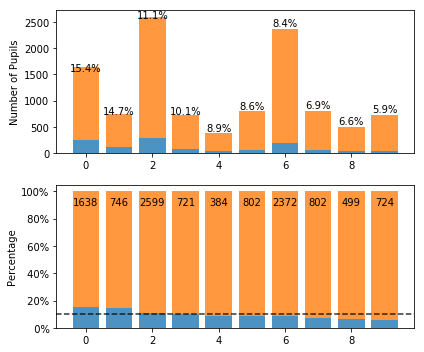

In [25]:
utility.plotlib.component_bar(y, group, n_components)

In [9]:
np.random.seed(0)
n_components = 10
n_trials = 10
map_predictions = {}

for trial in range(0, n_trials):
    print('Trial NO. = {}'.format(trial))
    gmm = mixture.GaussianMixture(
        n_components=n_components, 
        covariance_type='full',
        init_params='random',
        verbose=0, n_init=1, 
        tol=1e-6, max_iter=1000).fit(Xt_scaled)

    prediction = gmm.predict(Xt_scaled)
    map_predictions[trial] = prediction

Trial NO. = 0
Trial NO. = 1
Trial NO. = 2
Trial NO. = 3
Trial NO. = 4
Trial NO. = 5
Trial NO. = 6
Trial NO. = 7
Trial NO. = 8
Trial NO. = 9


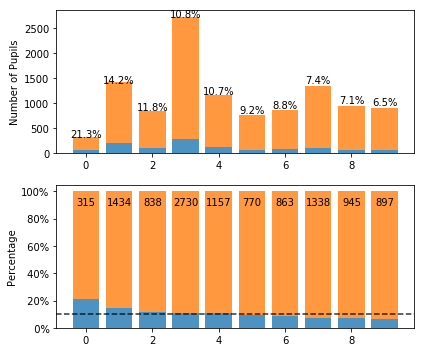

In [13]:
map_score = model.performance.compute_predictionScore(y, map_predictions, n_components, 'max_rate')

trial_ls = max(map_score, key=map_score.get)

utility.plotlib.component_bar(y, map_predictions[trial_ls], n_components)

In [16]:
n_components = 10
bic = []

for k in range(1, n_components+1):
    gmm = mixture.GaussianMixture(
        n_components=k, covariance_type='full', 
        verbose=0, n_init=1, 
        tol=1e-4, max_iter=1000).fit(Xt_scaled)
    bic.append(gmm.bic(Xt_scaled))
    print('Number of components = {}'.format(k))

Number of components = 1
Number of components = 2
Number of components = 3
Number of components = 4
Number of components = 5
Number of components = 6
Number of components = 7
Number of components = 8
Number of components = 9
Number of components = 10


Text(0.5,0,'Number of Components')

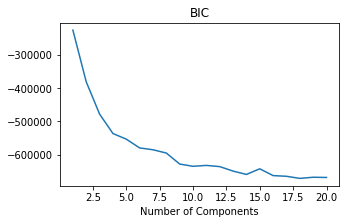

In [14]:
fig = plt.figure(figsize=(5,3))
ax = fig.add_subplot(111)
ax.plot(range(1, n_components+1), bic)
ax.set_title('BIC')
ax.set_xlabel('Number of Components')

## Bayesian Gaussian Mixture Model

In [26]:
n_components = 10
dpgmm = mixture.BayesianGaussianMixture(
    n_components=n_components, covariance_type='full', weight_concentration_prior=1e-2,
    weight_concentration_prior_type='dirichlet_process',
    mean_precision_prior=1e-2, covariance_prior=1e0 * np.eye(n_features),
    init_params="random", tol=1e-4, max_iter=10000, n_init=1, 
    verbose=2, verbose_interval=100).fit(X_scaled)

Initialization 0
  Iteration 0	 time lapse 0.16556s	 ll change inf
  Iteration 100	 time lapse 7.62758s	 ll change 0.00464
  Iteration 200	 time lapse 7.53583s	 ll change 0.00173
  Iteration 300	 time lapse 7.79913s	 ll change 0.00155
Initialization converged: True	 time lapse 25.72814s	 ll 220789.58979


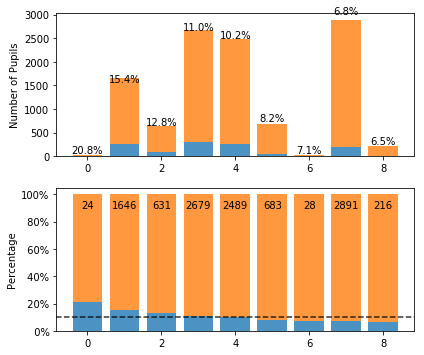

In [27]:
group = dpgmm.predict(X_scaled)

utility.plotlib.component_bar(y, group, n_components)

In [12]:
np.random.seed(0)
n_trials = 10
n_components = 10
prediction_list_dpgmm = {}

for trial in range(0, n_trials):
    print('Trial NO. = {}'.format(trial))
    dpgmm = mixture.BayesianGaussianMixture(
        n_components=n_components, covariance_type='full', weight_concentration_prior=1e-2,
        weight_concentration_prior_type='dirichlet_process',
        mean_precision_prior=1e-2, covariance_prior=1e0 * np.eye(n_features),
        init_params="random", tol=1e-4, max_iter=1000, n_init=1, 
        verbose=0, verbose_interval=100).fit(Xt_scaled)

    prediction = dpgmm.predict(Xt_scaled)
    prediction_list_dpgmm[trial] = prediction

Trial NO. = 0
Trial NO. = 1
Trial NO. = 2
Trial NO. = 3
Trial NO. = 4
Trial NO. = 5
Trial NO. = 6
Trial NO. = 7
Trial NO. = 8
Trial NO. = 9


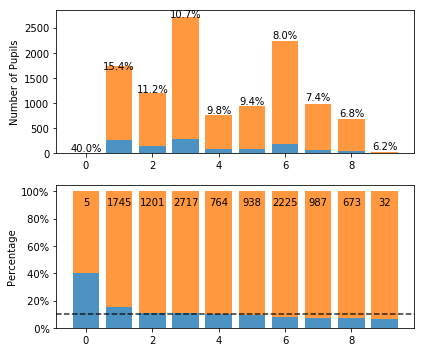

In [15]:
map_score_dpgmm = model.performance.compute_predictionScore(y, prediction_list_dpgmm, n_components, 'max_rate')
trial_ls = max(map_score_dpgmm, key=map_score_dpgmm.get)
utility.plotlib.component_bar(y, prediction_list_dpgmm[trial_ls], n_components)